<a href="https://colab.research.google.com/github/mshafi710/kttsdataenrichment/blob/main/Text_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO
 

1.   If a word/senetence contains characters not in the list of kashmiri keyboard characters, reject that for simplicity purposes
2.   Also delete the outliers from the dataset (too long sentences and too short)

In [56]:
#@title
# !pip install python-docx
# import docx
!pip install docx2txt
import docx2txt
from google.colab import drive
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os
import pathlib
import logging
drive.mount('/content/drive')
import nltk
import re
import pprint
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
from IPython.display import display, HTML
css_classes = """
<style>
  h1, h2, h3, h4 {
    color: red;
    font-size: 16px;
  }
  
  p {
    font-size: 14px;
    color: var(--text-color);
  }
</style>
"""
import IPython


if IPython.get_ipython() is not None:
  def  print_heading(text):  
    display(HTML(f'''{css_classes}<h5> {text} </h5>'''))
  
  def print_text(text, color='grey'):
    display (HTML(f''' {css_classes} <p style='--text-color:{color}'> {text}</p>'''))
  
else:
  def  print_heading(text):  
    print("\n")
    print (text)
    print("\n")

  def print_text(text, color='grey'):
    print (text)  

In [77]:
''' This code assumes two directories in the working directory  of the project. one for holding the raw corpus and second for holding the processed corpus'''
class Corpus:

 

  _instance = None
  _raw_corpus =""  
  _vocab_size = 0
  _raw_corpus_size =0
  _total_sentences=0
  _summary_generatable = False

  
  _sentence_char_lengths_list=[]  
  _sentence_token_lengths_list=[]
  # basic richness of a sentence is equal to the no of unique tokens in it.
  _basic_richness_list=[]
  _vocab= []  
  

  WORKING_DIR= '''/content/drive/MyDrive/PhD/Dataset/Text/text_files/'''  
  VOCAB_FILENAME="kashmiri_vocab.csv"

  PROCESSED_DIR = 'processed'
  CORPUS_DIR= 'corpus'
  ENRICHED_FILENAME_INITIAL="initial_kashmiri_enriched.csv"
  ENRICHED_FILENAME_FINAL = "final_kashmiri_enriched.csv"
  # LOG_FILE = '/processed/text-extraction.log'  
  #first letter in the TOKEN_DELIMITER_PATTERN is the Kashmiri fullstop character  
  TOKEN_DELIMITER_PATTERN = r"[۔;,:\-\s+\n+\(\)\"\?,]"
  SENTENCE_DELIMITER = r"[۔]"


  #-------Member Functions -------

  def __new__(cls):
    if not cls._instance:      
      cls._instance = super().__new__(cls)
      return cls._instance
    else:
      class_name = cls.__name__
      print("INFO! {} Class  is a Singleton ".format(class_name ))  
      return cls._instance 


  def __init__(self):
    pass
    # pprint.pprint((type(self).__dict__))  

  @classmethod
  def summary(cls):
    if cls._summary_generatable:
      return {
          'vocab_size(tokens)': cls._vocab_size,
          'raw_corpus_size(tokens)': cls. _raw_corpus_size,
          'total_sentences' : cls. _total_sentences,
          'average_sentence_length_char': sum(cls._sentence_char_lengths_list)/cls. _total_sentences, 
          'average_sentence_length_tokens': sum(cls._basic_richness_list)/ cls._total_sentences
      }
       
      

  @classmethod
  def read_corpus(cls):
    corpus_path= os.path.join(cls.WORKING_DIR, cls.CORPUS_DIR )
    file_list= os.listdir(corpus_path)
    for filename in tqdm(file_list, unit='item', desc="Reading Corpus",  ncols=80 ):
      file_path = os.path.join(corpus_path, filename)  # Create the full file path
      if os.path.isfile(file_path):  # Check if it's a file (not a directory)
          # Process the file as needed          
              print_text("Processing of [{}] file started".format(file_path))
              cls._raw_corpus = cls._raw_corpus + "\n" +  docx2txt.process(file_path)
              print_text("Processing of [{}] file ended".format(file_path))
    
    

  @classmethod
  def generate_vocab(cls):
    ''' return the vocabulary list (unique words in the given corpus)    
    writes vocab to the file with name in the VOCAB_FILE_NAME in the 
    working directory  set by the variable  WORKING_DIR'''
    trimmed_corpus = re.sub(cls.TOKEN_DELIMITER_PATTERN, " ", cls._raw_corpus)
    tokens = trimmed_corpus.split() 
    cls._raw_corpus_size= len(tokens)
    # print_heading("Overall Tokens ")
    # print_text (tokens)
    print_heading("------------------")
    print_text("No of Tokens (after excluding the punctuation)[raw corpus size]: %d"  % cls._raw_corpus_size)
    tokens.sort()
    # get the unique list using set operation
    vocab = list(set(tokens))
    vocab.sort()
    cls._vocab_size = len(vocab)
    print("Vocabulary Size: %d" %cls._vocab_size)  

    os.chdir(cls.WORKING_DIR)
    vocab_path = os.path.join(cls.WORKING_DIR , cls.PROCESSED_DIR , cls.VOCAB_FILENAME)
    with open (vocab_path,'w') as out:
      for token in tqdm(vocab, unit='it', desc='Generating Vocab', ncols=80):
        out.write(token+"\n")
    print_text("vocabulary stored in {} \n ".format( vocab_path))
    cls._vocab = vocab

  
  @classmethod
  def sentence_richness(cls, sentence):
    '''return the basic richness of the sentence: basic richnes is 
    equal to number of unique words of a sentence'''  
    #  replaces all occurrences of this pattern with a single space
    trimmed_sentence = re.sub(cls.TOKEN_DELIMITER_PATTERN, " ", sentence)
    tokens= trimmed_sentence.split()
    cls._sentence_token_lengths_list.append(len(tokens))
    # print_text("\n------In Richness ----{}----\n".format(len(tokens)),'cyan')
    # print (tokens)
    # print_text("\n-----Out Rchness ------------\n",'cyan')
    richness = len(set(tokens))
    return  richness

  @classmethod
  def basic_richness_sentence_wise(cls):
    sentences = re.split(cls.SENTENCE_DELIMITER,cls._raw_corpus)    
    print_heading('---------Before Processing-----------')
    print(" Total sentences: %d" % len(sentences))
    # for  index, sentence  in enumerate(sentences):
    #   print("{}th sntence : {}".format(str(index), str(sentence)))

    '''Filter out empty sentences while doing so, also replace the multiple 
    spaces with one space, remove parenthesis, commas , and quotes and alike
      as mentioned in the TOKEN_DELIMITER_PATTERN'''
    sentences = [re.sub(cls.TOKEN_DELIMITER_PATTERN, " ", sentence) \
                 for sentence in tqdm(sentences, unit= "it", \
                                      desc="Removing Punctuations and extra white spaces", ncols=80) if sentence.strip() ] 
    print_heading('-----------After processing---------')
    cls._total_sentences = len(sentences)
    print(" Total sentences: %d" % cls._total_sentences )
    # for  index, sentence  in enumerate(sentences):
    #   print("{}th sntence : {}".format(str(index), str(sentence)))   
    

    df= pd.DataFrame(columns=['sentence','richness'])      
    for index, sentence in tqdm(enumerate(sentences), unit="item", desc="Calculating basic richness", ncols=80) :
      #exclude empty sentences
      # print('Length of a sentence is {}'.format(len(sentence)))
      sent_len = len(sentence)
      if  sent_len > 0:     
           
        basic_richness= cls.sentence_richness(sentence)
        cls._sentence_char_lengths_list.append(sent_len)
        cls._basic_richness_list.append(basic_richness)
        df.loc[len(df)] =[sentence, basic_richness]
        # out.write(sentence +"," + str (basic_richness)+ "\n")
        # print_text("Processing {}th sentence ".format(index))
        # print(sentence + ": " +str(basic_richness) + "\n-------------------\n")
    os.chdir(cls.WORKING_DIR)  
    file_path = os.path.join(cls.WORKING_DIR, cls.PROCESSED_DIR, cls.ENRICHED_FILENAME_INITIAL)
    df.to_csv( file_path,index= False )
    print_text("Completed basic_richness_sentence_wise ","green")
    print("Summary Available")
    cls._summary_generatable=True

  @classmethod
  def generate_corpus_richness(cls):
    ''' reads the simple richness csv file pointed by RICHNESS_FILENAME into dataframe, sorts it  
    in descending order of richness, drops the rows with NA values in richness column in place
    ''' 
    file_path = os.path.join (cls.WORKING_DIR, cls.PROCESSED_DIR, cls.ENRICHED_FILENAME_INITIAL)
    df=pd.read_csv(file_path)
    df.columns=  ['sentence','richness']
    df=df.sort_values(by=['richness'], ascending=False)
    #drops the old index and make the changes in the df directly
    df.reset_index(drop=True, inplace=True)
    #removes the dataframes where the richness column has missing or NaN values
    df=df.dropna(subset=['richness'])
    # add a new column to the data frame for setting the status of whether any of the tokens of the sentence has matched to the wishlist or not. 
    # initially all sentences will have tokens which are in the wishlist. hence values are false.
    df=df.assign(Deleted=False)
    # file created for checking the temporary richness
    # df.to_csv(WORKING_DIR + "/processed/tmp_rich.csv")
    ''' calculate the richness of the sentences '''
    wishlist= set(cls._vocab)
    print_heading("Vocab Length:{}".format(len(wishlist)))
    for index, row in tqdm(df.iterrows(),total=len(df), unit='row', desc='Calculating the richness', ncols=80) :
        tokens= re.split(cls.TOKEN_DELIMITER_PATTERN, row['sentence'])  
        tokens = [token for token in tokens if token.strip() ]
        tokens = set(tokens)
        # print_text("Total Unique Tokens: {}".format(len(tokens)),'cyan')
        # print(tokens)

        ''' richness of a given sentence is the number of unique tokens matching 
        with the remaining vocab list i.e., the intersection of the unique 
        tokens (set) in the sentence and the remaining vocab'''  

        match_words = tokens & wishlist 
        not_matched = tokens - match_words
        if len(match_words) > 0:
          df.at[index,'richness'] = len(match_words)
          # print_text("\n--------match words---{}----\n".format(len(match_words)),"magenta")     
          # print_text(match_words)
          # print_text("\n--------Not matched words---{}----\n".format(len(not_matched)),"wheat")     
          # print_text(not_matched)
          '''update the  wishlist by set difference operation of the wishlist 
          and the match  tokens: excluding the matching tokens from the wishlist'''
          wishlist = wishlist - set(match_words)
        else:
          df.at[index,'Deleted']=True

        # print("Wishlist size remaining: %d " %len(wishlist) )
        # print("DF size remaining: %d " %len(df) )
        # print( "\n   ------------------- ")
    final_richness_file_path = os.path.join(cls.WORKING_DIR, cls.PROCESSED_DIR, cls.ENRICHED_FILENAME_FINAL)
    df.to_csv( final_richness_file_path )
    print_text('Final Richness saved to {}'.format(final_richness_file_path), "green")
    # Validate the richness with the vocab size
    richness_sum_deleted_false= df.loc[df['Deleted'] == False, 'richness'].sum()
    vocab_len= len(cls._vocab)
    if( richness_sum_deleted_false == vocab_len):
      print_text('Richness  Validated with sum = {}'.format(richness_sum_deleted_false))


    



In [78]:
mycorpus = Corpus()

In [79]:
mycorpus.read_corpus()

Reading Corpus:   0%|                                   | 0/1 [00:00<?, ?item/s]

Reading Corpus: 100%|███████████████████████████| 1/1 [00:01<00:00,  1.06s/item]


In [80]:
mycorpus.generate_vocab()

Vocabulary Size: 20882


Generating Vocab: 100%|██████████████| 20882/20882 [00:00<00:00, 1073811.76it/s]


In [81]:
mycorpus.basic_richness_sentence_wise()

 Total sentences: 5240


Removing Punctuations and extra white spaces: 100%|█| 5240/5240 [00:00<00:00, 95


 Total sentences: 5013


Calculating basic richness: 5013item [00:08, 621.30item/s]


Summary Available


In [82]:
mycorpus.generate_corpus_richness()

Calculating the richness: 100%|██████████| 5013/5013 [00:02<00:00, 2479.75row/s]


In [83]:
pprint.pprint(mycorpus.summary())

{'average_sentence_length_char': 83.85737083582686,
 'average_sentence_length_tokens': 14.00199481348494,
 'raw_corpus_size': 74205,
 'total_sentences': 5013,
 'vocab_size': 20882}


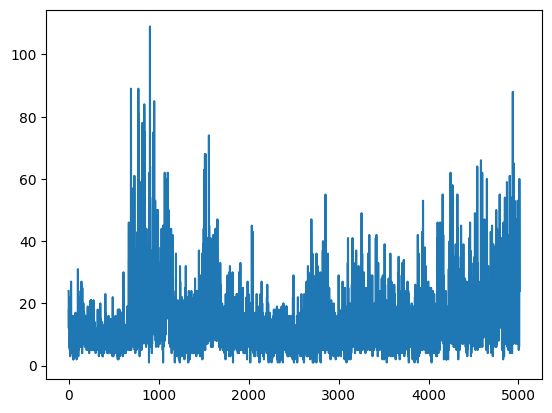

In [84]:

plt.plot(mycorpus._basic_richness_list)

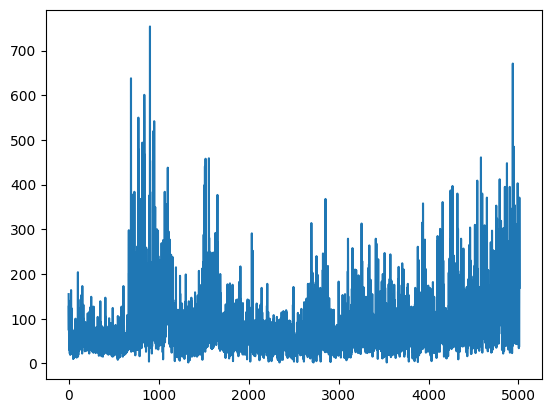

In [85]:
plt.plot(mycorpus._sentence_char_lengths_list)


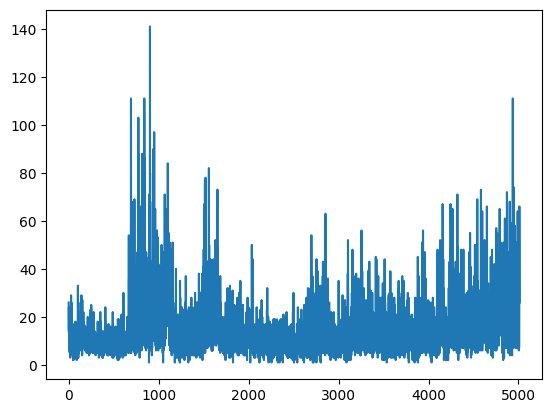

In [88]:

  plt.plot(mycorpus._sentence_token_lengths_list)